# Load data

In [142]:
import polars as pl

df = pl.read_csv('/mnt/data01/data/TreeSearch/data/from_organizers/train.csv')

In [143]:
luds = df['LudRules'].to_numpy()

all_agent1_strings = df['agent1'].to_numpy()
all_agent2_strings = df['agent2'].to_numpy()

all_agent1_win_counts = df['num_wins_agent1'].to_numpy()
all_draw_counts = df['num_draws_agent1'].to_numpy()
all_agent1_loss_counts = df['num_losses_agent1'].to_numpy()

print(all_agent1_strings[:5])
print(all_agent2_strings[:5])
print(all_agent1_win_counts[:5])
print(all_draw_counts[:5])
print(all_agent1_loss_counts[:5])

['MCTS-ProgressiveHistory-0.1-MAST-false'
 'MCTS-ProgressiveHistory-0.1-MAST-false'
 'MCTS-ProgressiveHistory-0.1-MAST-true'
 'MCTS-ProgressiveHistory-0.1-MAST-true'
 'MCTS-ProgressiveHistory-0.1-MAST-true']
['MCTS-ProgressiveHistory-0.6-Random200-false'
 'MCTS-UCB1GRAVE-0.6-NST-true' 'MCTS-UCB1-0.1-NST-false'
 'MCTS-UCB1-0.6-NST-false' 'MCTS-UCB1GRAVE-1.41421356237-NST-false']
[4 5 7 5 5]
[0 0 0 0 0]
[11 10  8 10 10]


# Compute elo ratings for each game

In [144]:
from tqdm import tqdm
import numpy as np

COMPONENT_NAMES = {
    'selection': ['UCB1', 'UCB1GRAVE', 'ProgressiveHistory', 'UCB1Tuned'],
    'exploration_const': ['0.1', '0.6', '1.41421356237'],
    'playout': ['Random200', 'MAST', 'NST'],
    'score_bounds': ['true', 'false']
}

unique_games = np.unique(luds)
games_to_components_to_options_to_elos = {}
games_to_components_to_options_to_match_counts = {}
games_to_components_to_options_to_unique_agents = {}
for game in tqdm(unique_games):
    # INITIALIZE ELOS & COUNTS.
    components_to_options_to_elos = {}
    components_to_options_to_match_counts = {}
    components_to_options_to_unique_agents = {}
    for component_name, options in COMPONENT_NAMES.items():
        components_to_options_to_elos[component_name] = {}
        components_to_options_to_match_counts[component_name] = {}
        components_to_options_to_unique_agents[component_name] = {}
        for option in options:
            components_to_options_to_elos[component_name][option] = 1000
            components_to_options_to_match_counts[component_name][option] = 0
            components_to_options_to_unique_agents[component_name][option] = set()

    # FILTER DATA.
    game_mask = (luds == game)
    agent1_strings = all_agent1_strings[game_mask]
    agent2_strings = all_agent2_strings[game_mask]
    agent1_win_counts = all_agent1_win_counts[game_mask]
    draw_counts = all_draw_counts[game_mask]
    agent1_loss_counts = all_agent1_loss_counts[game_mask]

    # UPDATE ELOS.
    MATCHES_PER_GAME = 10000
    for _ in range(MATCHES_PER_GAME):
        # PICK AGENT PAIR.
        selected_row_index = np.random.choice(len(agent1_strings))
        agent1_string = agent1_strings[selected_row_index]
        agent2_string = agent2_strings[selected_row_index]
        actual_outcome_counts = np.array([
            agent1_loss_counts[selected_row_index],
            draw_counts[selected_row_index],
            agent1_win_counts[selected_row_index]
        ])
        
        # SIMULATE OUTCOME.
        outcome = np.random.choice([0, 0.5, 1], p=actual_outcome_counts / actual_outcome_counts.sum())

        # UPDATE ELOS.
        agent_1_components = agent1_string.split('-')[1:]
        agent_2_components = agent2_string.split('-')[1:]
        for component_index, component_name in enumerate(COMPONENT_NAMES.keys()):
            # COMPUTE EXPECTED OUTCOME.
            agent_1_component = agent_1_components[component_index]
            agent_2_component = agent_2_components[component_index]
            
            agent_1_component_elo = components_to_options_to_elos[component_name][agent_1_component]
            agent_2_component_elo = components_to_options_to_elos[component_name][agent_2_component]
            
            agent_1_expected_outcome = 1 / (1 + 10 ** ((agent_2_component_elo - agent_1_component_elo) / 400))
            agent_2_expected_outcome = 1 / (1 + 10 ** ((agent_1_component_elo - agent_2_component_elo) / 400))

            # UPDATE ELOS.
            K_FACTOR = 4
            components_to_options_to_elos[component_name][agent_1_component] += K_FACTOR * (outcome - agent_1_expected_outcome)
            components_to_options_to_elos[component_name][agent_2_component] += K_FACTOR * ((1 - outcome) - agent_2_expected_outcome)

            # UPDATE MATCH COUNTS & AGENTS.
            components_to_options_to_match_counts[component_name][agent_1_component] += 1
            components_to_options_to_match_counts[component_name][agent_2_component] += 1

            components_to_options_to_unique_agents[component_name][agent_1_component].add(agent1_string)
            components_to_options_to_unique_agents[component_name][agent_2_component].add(agent2_string)

    # RECORD ELOS & COUNTS.
    games_to_components_to_options_to_elos[game] = components_to_options_to_elos
    games_to_components_to_options_to_match_counts[game] = components_to_options_to_match_counts
    games_to_components_to_options_to_unique_agents[game] = components_to_options_to_unique_agents

# COMPUTE UNIQUE AGENT COUNTS.
games_to_components_to_options_to_unique_agent_counts = {}
for game, components_to_options_to_unique_agents in list(games_to_components_to_options_to_unique_agents.items())[:10]:
    components_to_options_to_unique_agent_counts = {}
    for component_name, options_to_unique_agents in components_to_options_to_unique_agents.items():
        components_to_options_to_unique_agent_counts[component_name] = {
            option: len(unique_agents) 
            for option, unique_agents 
            in options_to_unique_agents.items()
        }

    games_to_components_to_options_to_unique_agent_counts[game] = components_to_options_to_unique_agent_counts


100%|██████████| 1373/1373 [09:06<00:00,  2.51it/s]


In [145]:
for game, results in list(games_to_components_to_options_to_elos.items())[:10]:
    print(f'{results}')

{'selection': {'UCB1': 988.6601072707916, 'UCB1GRAVE': 1011.6844991738467, 'ProgressiveHistory': 1008.3966516538493, 'UCB1Tuned': 991.2587419015134}, 'exploration_const': {'0.1': 992.0875208933, '0.6': 975.2970898182126, '1.41421356237': 1032.615389288493}, 'playout': {'Random200': 993.7067006471281, 'MAST': 966.5874456897772, 'NST': 1039.7058536630957}, 'score_bounds': {'true': 1007.4186394970168, 'false': 992.5813605029838}}
{'selection': {'UCB1': 978.8183979937382, 'UCB1GRAVE': 982.8510018363444, 'ProgressiveHistory': 970.4752094936274, 'UCB1Tuned': 1067.855390676286}, 'exploration_const': {'0.1': 942.0230834942577, '0.6': 1029.285642381972, '1.41421356237': 1028.6912741237804}, 'playout': {'Random200': 1015.6425739320188, 'MAST': 977.044736310034, 'NST': 1007.3126897579444}, 'score_bounds': {'true': 1002.9883316051315, 'false': 997.0116683948684}}
{'selection': {'UCB1': 1005.318273710114, 'UCB1GRAVE': 1017.9709057638765, 'ProgressiveHistory': 971.2160966139262, 'UCB1Tuned': 1005.49

In [146]:
for game, results in list(games_to_components_to_options_to_match_counts.items())[:10]:
    print(f'{results}')

{'selection': {'UCB1': 4760, 'UCB1GRAVE': 5842, 'ProgressiveHistory': 4873, 'UCB1Tuned': 4525}, 'exploration_const': {'0.1': 6347, '0.6': 6778, '1.41421356237': 6875}, 'playout': {'Random200': 6695, 'MAST': 7027, 'NST': 6278}, 'score_bounds': {'true': 9667, 'false': 10333}}
{'selection': {'UCB1': 4834, 'UCB1GRAVE': 4720, 'ProgressiveHistory': 4819, 'UCB1Tuned': 5627}, 'exploration_const': {'0.1': 7885, '0.6': 5019, '1.41421356237': 7096}, 'playout': {'Random200': 5844, 'MAST': 7041, 'NST': 7115}, 'score_bounds': {'true': 9955, 'false': 10045}}
{'selection': {'UCB1': 3481, 'UCB1GRAVE': 5241, 'ProgressiveHistory': 4714, 'UCB1Tuned': 6564}, 'exploration_const': {'0.1': 5447, '0.6': 6256, '1.41421356237': 8297}, 'playout': {'Random200': 7522, 'MAST': 6916, 'NST': 5562}, 'score_bounds': {'true': 0, 'false': 20000}}
{'selection': {'UCB1': 5519, 'UCB1GRAVE': 4820, 'ProgressiveHistory': 4272, 'UCB1Tuned': 5389}, 'exploration_const': {'0.1': 7490, '0.6': 5949, '1.41421356237': 6561}, 'playout':

In [147]:
for game, results in list(games_to_components_to_options_to_unique_agent_counts.items())[:10]:
    print(f'{results}')

{'selection': {'UCB1': 18, 'UCB1GRAVE': 18, 'ProgressiveHistory': 18, 'UCB1Tuned': 18}, 'exploration_const': {'0.1': 24, '0.6': 24, '1.41421356237': 24}, 'playout': {'Random200': 24, 'MAST': 24, 'NST': 24}, 'score_bounds': {'true': 36, 'false': 36}}
{'selection': {'UCB1': 17, 'UCB1GRAVE': 16, 'ProgressiveHistory': 16, 'UCB1Tuned': 18}, 'exploration_const': {'0.1': 23, '0.6': 21, '1.41421356237': 23}, 'playout': {'Random200': 20, 'MAST': 23, 'NST': 24}, 'score_bounds': {'true': 34, 'false': 33}}
{'selection': {'UCB1': 8, 'UCB1GRAVE': 9, 'ProgressiveHistory': 9, 'UCB1Tuned': 9}, 'exploration_const': {'0.1': 12, '0.6': 12, '1.41421356237': 11}, 'playout': {'Random200': 12, 'MAST': 12, 'NST': 11}, 'score_bounds': {'true': 0, 'false': 35}}
{'selection': {'UCB1': 18, 'UCB1GRAVE': 18, 'ProgressiveHistory': 16, 'UCB1Tuned': 17}, 'exploration_const': {'0.1': 24, '0.6': 21, '1.41421356237': 24}, 'playout': {'Random200': 22, 'MAST': 24, 'NST': 23}, 'score_bounds': {'true': 34, 'false': 35}}
{'sel

# Save elo ratings & statistics

In [148]:
import json

with open('ground_truth/run_2.json', 'w') as f:
    json.dump({
        'elos': games_to_components_to_options_to_elos,
        'match_counts': games_to_components_to_options_to_match_counts,
        'unique_agent_counts': games_to_components_to_options_to_unique_agent_counts
    }, f, indent=4)

# Check correlation between runs

In [169]:
from scipy.stats import pearsonr

run_0_elos = json.load(open('ground_truth/run_0.json'))['elos']
flattened_run_0_elos = []
for game, components_to_options_to_elos in run_0_elos.items():
    for component_name, options_to_elos in components_to_options_to_elos.items():
        if component_name != 'exploration_const':
            continue

        for option, elo in options_to_elos.items():
            flattened_run_0_elos.append(elo)

run_1_elos = json.load(open('ground_truth/run_1.json'))['elos']
flattened_run_1_elos = []
for game, components_to_options_to_elos in run_1_elos.items():
    for component_name, options_to_elos in components_to_options_to_elos.items():
        if component_name != 'exploration_const':
            continue
        
        for option, elo in options_to_elos.items():
            flattened_run_1_elos.append(elo)

pearsonr(flattened_run_0_elos, flattened_run_1_elos)

PearsonRResult(statistic=0.8964549180132525, pvalue=0.0)

In [166]:
from scipy.stats import spearmanr

spearmanr(flattened_run_0_elos, flattened_run_1_elos)

SignificanceResult(statistic=0.8923505082151053, pvalue=0.0)

In [167]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(flattened_run_0_elos, flattened_run_1_elos)

21.223293428466185

In [170]:
dummy_predictions = [1000] * len(flattened_run_0_elos)
root_mean_squared_error(flattened_run_0_elos, dummy_predictions)

43.956192379082076

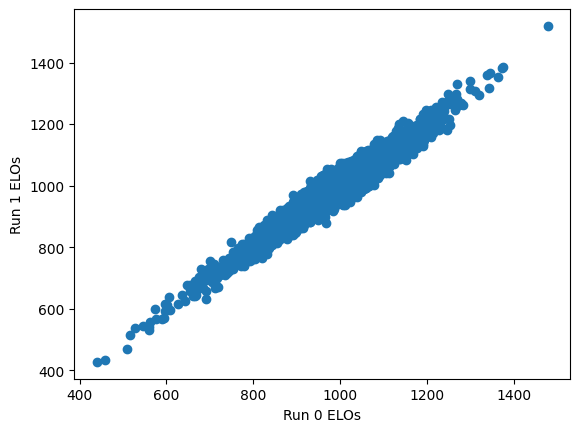

In [154]:
from matplotlib import pyplot as plt

plt.scatter(flattened_run_0_elos, flattened_run_1_elos)

plt.xlabel('Run 0 ELOs')
plt.ylabel('Run 1 ELOs')

plt.show()

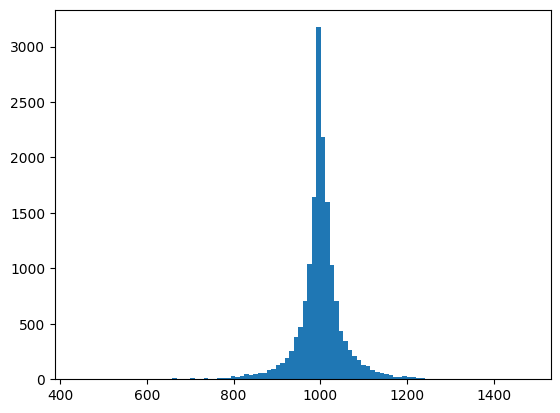

In [158]:
plt.hist(np.array(flattened_run_0_elos), bins=100)

plt.show()

In [162]:
print(np.mean(flattened_run_0_elos), np.std(flattened_run_0_elos))
print(np.std(np.array(flattened_run_0_elos) - flattened_run_1_elos))

1000.0 58.517804583595606
19.858274122547837
